# Goat City: Vaccination Status Prediction
Authors: 
- [Danielle Rossman](https://github.com/dmrossm)
- [Matthew Turner](https://github.com/austint1121)
- [Hyunwook Paul Shin](https://github.com/hps1795)

<img src="Images/goat-vaccination.jpg" width="100%" height="100%">

## Overview:

The fictional mayor of the fictional city, Goat city, TN,  is ordering Covid vaccines, and is fully aware that not
everyone will choose to get vaccinated. Goat city wants to know how many Covid vaccines they should be ordering.
They have hired us, the Flatiron GOATS, to assist them with this task.

National 2009 H1N1 Flu Survey collected to monitor vaccination rates during that campaign. This phone survey asked
people whether they had received H1N1 vaccines, in conjunction with information they shared about their lives, opinions,
and behaviors. We want to use this data to create a model that can predict if a person received the H1N1 Vaccine based on
their responses to the questions in the survey. Then advise Goat City to use the model we have created with the
provided H1N1 survey data to now predict the number of COVID-19 vaccines needed.





- Our model predicted that **Goat city should order 8309** doses of the H1N1 vaccine, and **it would cost ~$66,472**.


- Goat city actually **ordered 5674 doses** of the H1N1 vaccine,and spent **~$45,932 on vaccine doses**.

Our model was off by **~2,635 doses, a difference of $20,540**

Given the ~80% accuracy of this model, we can confidently advise Goat City to conduct an updated
survey, targeting the same demographic features, but shifting the survey questions regarding vaccines and likelihood of
illness to focus on the current COVID-19 epidemic. We then advise Goat City to use the model we have created with the
provided H1N1 survey data to now predict the number of COVID-19 vaccines needed.


## Business Problem:
- The mayor of Goat city is ordering Covid vaccines, and is fully aware that not everyone will choose to get vaccinated. Goat city wants to know how many Covid vaccines they should be ordering. We want to show them that using a survey to predict if a person will get a vaccine is a valid way of estimating how many vaccines to order.

#### Dataset: Data sourced from DataDriven Datadriven description of the dataset says:

>Vaccines for H1N1 were first publicly available in the United States in October 2009, when the United States government began a vaccination campaign. We will look at data from the National 2009 H1N1 Flu Survey collected to monitor vaccination rates during that campaign. This phone survey asked people whether they had received H1N1 and seasonal flu vaccines, in conjunction with information they shared about their lives, opinions, and behaviors. A better understanding of how these characteristics have been associated with personal vaccination patterns may provide guidance for future public health efforts.
>
Full documentation of the dataset can be found on the [CDC website](https://www.cdc.gov/nchs/nis/data_files_h1n1.htm)

The data has already been split into a train and test set, however, we do not have access to the testing set's labels. For now, our group will be focusing ONLY on the h1n1 vaccine label.

## Exploratory Data Analysis

- **Stakeholder**
    - Goat City Government/ Health Department
- **Target**
    - H1N1
- **Cost of different errors FP/FN**
    - False Positive:
        - Model predicts they will get the vaccine, but didn't.
        - Ordering too many vaccines and wasting money/material
    - False Negative:
        - Model predicts they won't get the vaccine, but did.
        - Vaccine shortage, Loss of life, increased hospitaliazations
- **Metric:**
    - Recall
    - F1-score

In [86]:
#Required imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, recall_score, f1_score, plot_confusion_matrix
from catboost import CatBoostClassifier
from functions import metrics
import warnings
warnings.filterwarnings(action='ignore')

In [88]:
# Training labels
training_labels = pd.read_csv('Data/training_set_labels.csv', index_col='respondent_id')
training_features = pd.read_csv('Data/training_set_features.csv', index_col='respondent_id')

- Lets look into the details of each dataset. 
- The features_df and training_labels will be X within our models.
- The lables_df and training_features will be y within our models.

In [90]:
# Visually confirm expected results
training_features

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN


In [91]:
# Checking features statistics
training_features.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


- It appears that ALL of these are categorical variables/features, because there are no "true" floats.

In [92]:
# Checking Data Types
training_features.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

- We are most likley going to have to OneHotEncode most of these features.

### Checking for NaN Values

In [93]:
# Checking Features
training_features.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [94]:
# Checking labels
training_labels.isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

- This survey data contains both demographic information (e.g., rent/own, marital status, income level, household size, race, gender, age, etc.), as well as information regarding opinions on relevant health topics (e.g., efficacy and side effects of both the H1N1 and seasonal flu vaccines, knowledge and concern about H1N1 infection (swine flu).
<br/>

- We also found that three columns contained encoded data in order to protect the privacy of patients, and thus maintain their HIPAA rights (i.e., health and human services geographical region, industry and occupation). (This is generally done when any single group is small enough to “hint” at the identities of the individuals within that group.) We have left this information in its encoded form, as it still informs our models, regardless of encoding.

### Data Preparation

- Our X will be all the variables in training_features, y will be the 'h1n1 vaccine' survey data from training_labels.

For the preprocessing, all of the columns are categorical, however, some of them are numerical, and some of them are strings. We will want to handle these columns differently when imputing missing values.

- **Numerical Categories**
    - Use Sklearn's [Iterative Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html_) to fill in the missing values
- **String Categories**
    - Fill missing values with a new value: 'unknown'
    - One hot encode the results
- **Categories with more then 10 unique categories**
  - We will frequency code these instead, so we don't have an overwhelming amount of columns in the dataframe.


In [95]:
X = training_features
y = training_labels[['h1n1_vaccine']] #we are dropping the "seasonal_vaccine" column

In [96]:
#X.drop(columns=['respondent_id'], inplace= True)

In [97]:
X['health_insurance'].value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

In [98]:
X['health_insurance'].isna().sum()

12274

In [99]:
X['health_insurance'].fillna(2)

0        1.0
1        1.0
2        2.0
3        2.0
4        2.0
        ... 
26702    2.0
26703    1.0
26704    2.0
26705    0.0
26706    1.0
Name: health_insurance, Length: 26707, dtype: float64

In [100]:
X['employment_industry'].isna().sum()

13330

In [101]:
X['employment_occupation'].isna().sum()

13470

In [102]:
X['employment_industry'].value_counts()

fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

In [103]:
X['employment_occupation'].value_counts()

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64

The following process was obtained from following source, as cited:
- Berlin L. Lindseyberlin/Cat-in-the-dat-project. GitHub. https://github.com/lindseyberlin/Cat-in-the-Dat-Project. Published October 17, 2021.

We will split the data into use set and hold set. Use set will be the one we will use to train and validate the model. Hold set will be our technical test set.

In [104]:
# split use and hold 
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, random_state=0)

# split train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_test = X_val #

In [105]:
# initialize three columns
num_cols = []
ohe_cols = []
freq_cols = []

In [106]:
# make the lists of columns
# num = any columns with numerical value
# ohe = any columns with object value with less than 10 unique values
# freq = any columns with object value with 10 or more unique values
for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

- Let's check which columns are in each list. (sanity check)

In [107]:
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [108]:
ohe_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa']

In [109]:
freq_cols

['hhs_geo_region', 'employment_industry', 'employment_occupation']

In [110]:
num_transformer = Pipeline(steps=[
    ('minmaxscaler', MinMaxScaler()),
    ('num_imputer', IterativeImputer(max_iter = 15))
    ])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore'))
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

- Combine 3 pipelines using ColumnTransformer to create 1 preprocessor. Then, fit the preprocessor to X_train dataset.

In [111]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [112]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('num_imputer',
                                                  IterativeImputer(max_iter=15))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doc...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  

## Modeling

### 1. Modeless Baseline

In [113]:
# Modeless Baseline
training_labels['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

- In this context, a modeless baseline would have an accuracy of ~0.79 and would guess 0 every single time.

([<matplotlib.axis.XTick at 0x129abc610>,
 [Text(0, 0, 'Unvaccinated'), Text(1, 0, 'Vaccinated')])

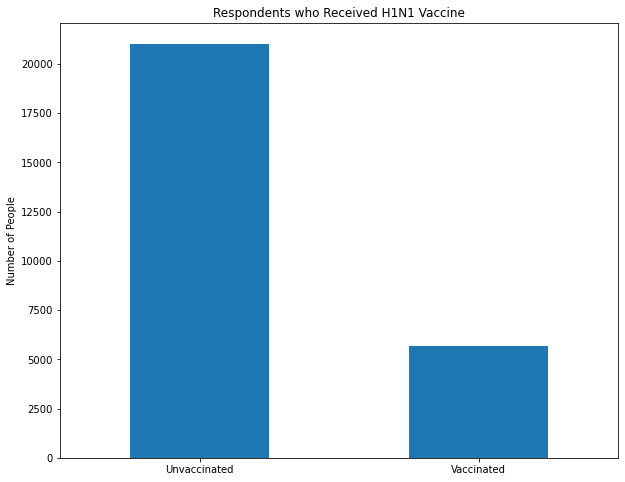

In [114]:
# Visual for distribution of people who received the H1N1 Vaccine
fig, ax = plt.subplots(figsize=(10,8))

(training_labels['h1n1_vaccine'].value_counts().plot.bar(title="Respondents who Received H1N1 Vaccine", ax=ax))
ax.set_ylabel("Number of People")
plt.xticks([0, 1], ['Unvaccinated', 'Vaccinated'], rotation=0);

### 2. Logistic Regression
Our first model will be logistic regression. We will start with no parameters

In [115]:
# Create a pipeline combining preprocessor and classifier
# classifier = LogisticRegression()
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [116]:
# Cross validate the model
cross_validate(lr_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([2.97452426, 3.16811609, 2.89325309, 3.18234587, 2.80406713]),
 'score_time': array([0.07951093, 0.08218884, 0.07795787, 0.0784688 , 0.07684088]),
 'test_score': array([0.83781886, 0.83922303, 0.83758484, 0.83407442, 0.83079803]),
 'train_score': array([0.83582963, 0.83612216, 0.83618067, 0.83770185, 0.83840393])}

- Cross validation shows that there is no overfitting.

In [117]:
# fit the model
lr_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [118]:
# Predict on validation set
lr_preds = lr_clf.predict(X_val)
X_val

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
17088,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Principle City",0.0,0.0,NaN,NaN
1971,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Below Poverty,Married,Rent,Not in Labor Force,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,NaN,NaN
16698,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lzgpxyit,"MSA, Principle City",2.0,0.0,fcxhlnwr,cmhcxjea
22074,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,kbazzjca,"MSA, Not Principle City",0.0,0.0,fcxhlnwr,cmhcxjea
21458,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,mlyzmhmf,"MSA, Principle City",1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10623,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,"MSA, Principle City",0.0,0.0,wxleyezf,emcorrxb
5289,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,Not Married,NaN,Not in Labor Force,lzgpxyit,Non-MSA,0.0,0.0,NaN,NaN
24237,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"> $75,000",Married,Own,Employed,mlyzmhmf,Non-MSA,1.0,0.0,pxcmvdjn,uqqtjvyb
5689,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,kbazzjca,"MSA, Principle City",0.0,0.0,fcxhlnwr,kldqjyjy


- Based on the prediction, we will caculate the metrics: accuracy, recall, f1, and roc_auc.

In [119]:
metrics(y_val, lr_preds)

accuracy: 0.823
recall 0.402
f1: 0.498
roc_auc: 0.671


- Although the accuracy is high, recall and f1 is less than 0.5. AUC might be at the higher side.

- We will also generate the confusion matrix to visualize the FN/FP cases.

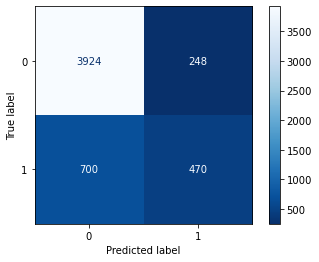

In [120]:
plot_confusion_matrix(lr_clf, X_val, y_val, cmap = "Blues_r")

### 3. Naive Bayesian
Our second model will be Gaussian Naive Bayesian.

In [121]:
nb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [122]:
cross_validate(nb_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([3.32984018, 2.77587032, 3.04978395, 2.96457696, 4.14445496]),
 'score_time': array([0.08815074, 0.08311772, 0.08373904, 0.08473611, 0.16537714]),
 'test_score': array([0.76199392, 0.75520711, 0.76222794, 0.7516967 , 0.75567517]),
 'train_score': array([0.76029722, 0.75702083, 0.75579218, 0.75912708, 0.75889305])}

- Cross validation shows that there is no overfitting.

In [123]:
nb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [124]:
nb_preds = nb_clf.predict(X_val)

In [125]:
metrics(y_val, nb_preds)

accuracy: 0.756
recall: 0.623
f1: 0.528
roc_auc: 0.708


- Accuracy score is lower than Logistic Regression. However, recall, f1, ROC_AUC is higher than those of the baseline Logistic Regression Model.

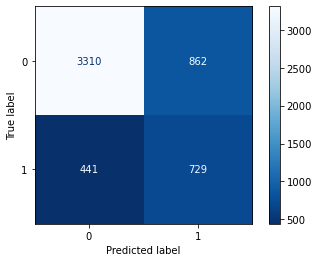

In [126]:
plot_confusion_matrix(nb_clf, X_val, y_val, cmap="Blues_r")

- Confusion Matrix shows that recall is higher than Precision.

### 4. KNN

Our third model is the K-nearest neighbors.

In [127]:
knn_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [128]:
knn_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [129]:
knn_preds = knn_clf.predict(X_val)

In [130]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, knn_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, knn_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, knn_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , knn_preds)))

accuracy: 0.799
recall: 0.250
f1: 0.353
roc_auc: 0.602


- Every score seems really low else than accuracy. We will not try to tune this model since the KNN takes a lot of time to run and the model score does not seem promising.

### 5. Decison Tree
Our fifth model is Decision Tree.

In [137]:
clf_decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [139]:
clf_decision_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [138]:
cross_validate(clf_decision_tree, X_train, y_train, return_train_score=True)

{'fit_time': array([4.337749  , 5.39416075, 4.23977089, 6.35420799, 4.9369452 ]),
 'score_time': array([0.25302696, 0.12656426, 0.10296798, 0.10640574, 0.08476377]),
 'test_score': array([0.78188626, 0.7830564 , 0.77767377, 0.77907793, 0.76456822]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [140]:
decision_tree_preds = clf_decision_tree.predict(X_val)

In [141]:
metrics(y_val, decision_tree_preds)

accuracy: 0.765
recall: 0.474
f1: 0.469
roc_auc: 0.660


- We performed a grid search for this model, and have linked to it in the section **Links for further gridsearch**. Due to the low recall score (0.437) and low f1 score (0.554), it is not included in this notebook, and we have decided to continue modeling as these scores are far from optimal.

### 6. Random Forest
Our fourth model is Random Forest.

In [131]:
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])


In [132]:
cross_validate(rf_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([9.78645825, 5.35995698, 5.43429017, 5.76717997, 5.27914476]),
 'score_time': array([0.17467499, 0.21096802, 0.17369485, 0.17136812, 0.17230535]),
 'test_score': array([0.85186052, 0.85537093, 0.84975427, 0.85162649, 0.83969108]),
 'train_score': array([1.        , 0.99994149, 1.        , 1.        , 0.99994149])}

- Cross validation score shows that the model is overfitting. The parameter tuning is needed to modify this.

In [133]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [134]:
rf_preds = rf_clf.predict(X_val)

In [135]:
metrics(y_val, rf_preds)

accuracy: 0.842
recall: 0.423
f1: 0.540
roc_auc: 0.692


- Most of the score looks high enough. We might want to try out the grid search to modify the scores since the recall is the lowest out of the models we have tried (excluding KNN).

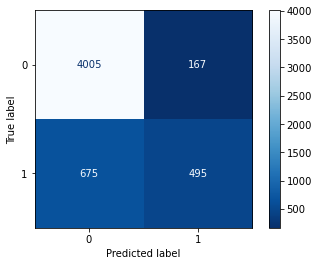

In [136]:
plot_confusion_matrix(rf_clf, X_val, y_val, cmap="Blues_r")

- As we can see the precision is really high but recall is relatively low.

### 7. Catboost
Finally, since all of our data is categorical we will use catboost to create our sixth final model.

In [143]:
cat_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catboost_clf', CatBoostClassifier(verbose=False))
])

In [144]:
cat_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [145]:
metrics(y_val, cat_clf.predict(X_test))

accuracy: 0.850
recall: 0.497
f1: 0.592
roc_auc: 0.723


- Catboost did about as well as XGboost did, but the biggest thing I noticed is that it took 1/4 of the amount of time to train. I think this would be a much better model type to use going forward.

#### 7.1 Catboost Tuning

In [146]:
# Create pipleline with tuned params
tuned_cat_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Changing the eval metric from "logloss" to "AUC" and modifying the learning rate
    ('catboost_clf', CatBoostClassifier(learning_rate=0.03,
    eval_metric='AUC', verbose=False))
])

In [147]:
# Fit the new model
tuned_cat_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [148]:
# Calculate metrics
metrics(y_val, tuned_cat_clf.predict(X_test))

accuracy: 0.850
recall: 0.494
f1: 0.590
roc_auc: 0.722


#### 7.2 More Tuned Catboost

In [149]:
tuned_cat_clf2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # For these parameters, I selected many common hypertuning parameters and gave them a generic value
    ('catboost_clf2', CatBoostClassifier(eval_metric='AUC', iterations=500, verbose=False,
                                         random_strength=5,
                                         bagging_temperature=5,
                                         max_bin=5,
                                         grow_policy='Lossguide',
                                         min_data_in_leaf=5,
                                         max_depth=5,
                                         l2_leaf_reg=10,
                                         auto_class_weights='Balanced'))
])

In [150]:
tuned_cat_clf2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [151]:
metrics(y_val, tuned_cat_clf2.predict(X_test))

accuracy: 0.798
recall: 0.737
f1: 0.615
roc_auc: 0.776


- Conclusion:
Just from manually adding some parameters and tuning them by hand, we have a significant increase to our metrics.

#### 7.3 Catboost Tuning: Min Trees/Max_leaves

In [152]:
tuned_cat_clf3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # For these parameters, I selected many common hypertuning parameters and gave them a generic value
    ('catboost_clf3', CatBoostClassifier(eval_metric='AUC', verbose=False, iterations=500,
                                         loss_function='Logloss',
                                         random_strength=4,
                                         bagging_temperature=3,
                                         max_bin=5,
                                         grow_policy='Lossguide',
                                         min_data_in_leaf=5,
                                         max_depth=5,
                                         l2_leaf_reg=300,
                                         auto_class_weights='Balanced',
                                         best_model_min_trees=3,
                                         max_leaves=30
                                         ))
])

In [153]:
tuned_cat_clf3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [154]:
metrics(y_val, tuned_cat_clf3.predict(X_test))

accuracy: 0.794
recall: 0.749
f1: 0.615
roc_auc: 0.778


- Conclusion: Tuning the parameters: Min Trees and Max_leaves, we have an increase to our metrics. This will be our final model.

## Conclusion:
<br/>

- Our final model was able to predict the number of vaccines used during the 2009 H1N1 epidemic (for the sample provided), with an error that was equivalent to a total dollar cost of ~$21,000. Given the average budget of most local public health departments this is a highly tolerable error in terms of monetary cost.
<br/>

- Of note, in choosing to minimize fatalities, we thus prioritized life over monetary loss. Also of note, underestimating the number of needed vaccines would not only have cost more lives, but would have created additional monetary burden in the form of hospital bills for unvaccinated/infected patients. As hospital costs are exponentially greater than the cost of vaccines, we feel that our choice to design a model that restricted the chance of those wishing to be vaccinated from encountering a vaccine shortage was optimal.
<br/>

- We now feel, that given the ~80% accuracy of this model, we can confidently in advise Goat City to conduct an updated survey, targeting the same demographic features, but shifting the survey questions regarding vaccines and likelihood of illness to focus on the current COVID-19 epidemic. We then advise Goat City to use the model we have created with the provided H1N1 survey data to now predict the number of COVID-19 vaccines needed.
<br/>

- Once again, because we have built a model that will tolerate overestimation of vaccines needed far more readly than underestimation, we feel that in using this model to predict vaccines needed, there is relatively low likelihood of encountering vaccine shortage. This will optimally position Goat City to slow and hopefully halt local spread of infection, while also giving its health department vital knowledge on how many individuals may need to be swayed, via public health education campaigns and extremely convenient vaccine clinics, to choose to become vaccinated. This additional knowledge will thus also be extremely useful in guiding budgetary decision-making in an effort to decrease fataltities.

## Links for further gridsearch
- [Logistic Regression / Naive-Bayesian / KNN / Random Forest](https://github.com/austint1121/Flatiron_GOATS_Vaccination_Prediction/blob/Paul/Notebooks/Paul/Paul_Final_Notebook.ipynb)
- [Decision Tree](https://github.com/austint1121/Flatiron_GOATS_Vaccination_Prediction/blob/Danielle/Notebooks/Danielle/Danielle_Notebook.ipynb)
- [CatBoost](https://github.com/austint1121/Flatiron_GOATS_Vaccination_Prediction/blob/Matthew/Notebooks/Matthew/Matthew-Modeling.ipynb)